In [1]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [2]:
data_dir = 'numpy_arrays'
X  = 'train_digit_features.npy'
y  = 'train_digit_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

print("Features:",train_features.shape)
print("Labels", train_labels.shape)

Features: (73257,)
Labels (73257,)


LABEL: 3.0
LABEL: 3.0
LABEL: 9.0


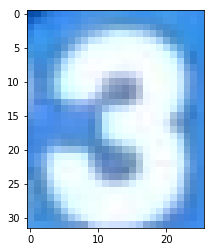

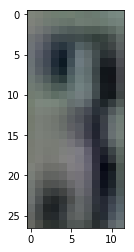

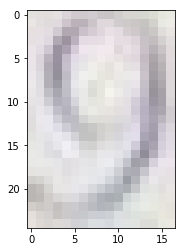

In [3]:
%matplotlib inline

def display(feature_array, label_array, num):
    print("LABEL: {}".format(label_array[num]))
    fig,ax  = plt.subplots(1)
    ax.imshow(feature_array[num])

display(train_features, train_labels, 3)
display(train_features, train_labels, 4000)
display(train_features, train_labels, -1)

In [4]:
# Preprocessing features
from skimage.transform import resize
%matplotlib inline

def remove_zero_dims(features, labels):
    skimmed_features = []
    skimmed_labels   = []
    
    for i, feature in enumerate(features):
        height, width = feature.shape[0], feature.shape[1]
        to_height = 25
        try:
            to_width = to_height * ( (1.0 * width) / height)
            tmp = resize(feature, (int(to_height), int(to_width), 3), mode='constant')
            skimmed_features.append(feature)
            skimmed_labels.append(labels[i])
        except Exception as e:
            print("ERROR: {}. DIMS: {} {} {}".format(e, i, height, width))

    return np.array(skimmed_features), np.array(skimmed_labels)

        
tmp_features, tmp_labels = remove_zero_dims(train_features, train_labels)
print(tmp_features.shape)
print(tmp_labels.shape)

ERROR: float division by zero. DIMS: 543 30 0
ERROR: float division by zero. DIMS: 1571 108 0
ERROR: float division by zero. DIMS: 6875 38 0
ERROR: float division by zero. DIMS: 11710 40 0
ERROR: float division by zero. DIMS: 15150 69 0
ERROR: float division by zero. DIMS: 20600 46 0
ERROR: float division by zero. DIMS: 26065 33 0
ERROR: float division by zero. DIMS: 28859 32 0
ERROR: float division by zero. DIMS: 33178 17 0
ERROR: float division by zero. DIMS: 40034 68 0
ERROR: float division by zero. DIMS: 40296 30 0
ERROR: float division by zero. DIMS: 42428 46 0
ERROR: float division by zero. DIMS: 44972 39 0
ERROR: float division by zero. DIMS: 45752 49 0
ERROR: float division by zero. DIMS: 45780 53 0
ERROR: float division by zero. DIMS: 49123 16 0
ERROR: float division by zero. DIMS: 52328 46 0
ERROR: float division by zero. DIMS: 58190 64 0
ERROR: float division by zero. DIMS: 60511 50 0
ERROR: float division by zero. DIMS: 60866 54 0
ERROR: float division by zero. DIMS: 62449 

LABEL: 3.0
LABEL: 9.0
LABEL: 9.0


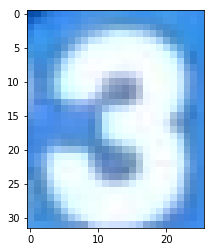

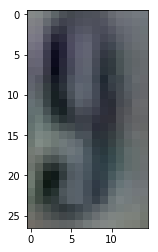

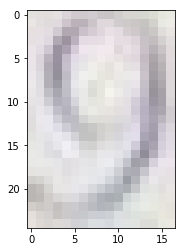

In [5]:
display(tmp_features, tmp_labels, 3)
display(tmp_features, tmp_labels, 4000)
display(tmp_features, tmp_labels, -1)

In [6]:
def crop(features, to_height):
    #mean_width = np.mean([f.shape[1] for f in features])
    #print("MEAN WIDTH: {}".format(mean_width))
    
    tmp_resized_features = []
    for i, feature in enumerate(features):
        #print(feature.shape)
        height, width = feature.shape[0], feature.shape[1]

        to_width = to_height * ( (1.0 * width) / height)
        #tmp = resize(feature, (int(to_height), int(to_width), 3), mode='constant')
        tmp = resize(feature, (50, 25, 3), mode='constant')
        #print(tmp.shape)
        tmp_resized_features.append(tmp)
        
    return np.array(tmp_resized_features)

def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])

cropped_images = crop(tmp_features, 50)
resized_images = resize_32x32(tmp_features)
print(cropped_images.shape)
print(resized_images.shape)

(73227, 50, 25, 3)
(73227, 32, 32, 3)


LABEL: 3.0
LABEL: 9.0
LABEL: 9.0
LABEL: 3.0
LABEL: 9.0
LABEL: 9.0


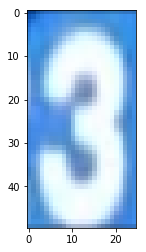

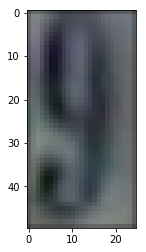

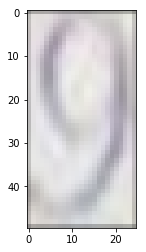

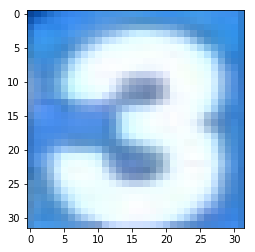

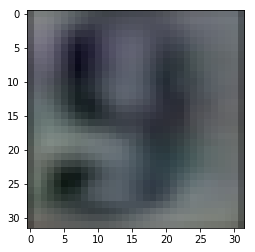

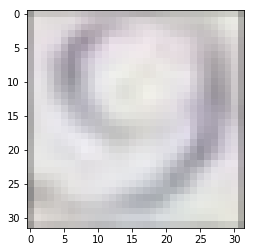

In [7]:
display(cropped_images, tmp_labels, 3)
display(cropped_images, tmp_labels, 4000)
display(cropped_images, tmp_labels, -1)

display(resized_images, tmp_labels, 3)
display(resized_images, tmp_labels, 4000)
display(resized_images, tmp_labels, -1)

LABEL: 6.0


array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

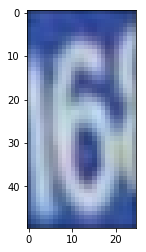

In [8]:
# Preprocessing targets

# Removing labels that are not 0 - 9.
tmp_labels[tmp_labels == 10.0] = 0.0

# One hot encoding
encoded_labels = to_categorical(tmp_labels)

pic = 7000
display(cropped_images, tmp_labels, pic)
encoded_labels[pic]

In [9]:
# Models

def dense_model(in_shape):
    model = Sequential()
    model.add(Dense(32, input_shape=in_shape))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model

def pooling_model(in_shape):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=in_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model

def thick_model(in_shape):
    model = Sequential()
    model.add(Conv2D(filters=48, kernel_size=2, padding='same', activation='relu', input_shape=in_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=160, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model


In [10]:
features = resized_images
targets  = encoded_labels
model    = thick_model(features.shape[1:])

print(features.shape)
print(targets.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        12352     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         32896     
__________

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint
from time import time

start      = time()
epochs     = 50
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'model_digits_' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True, monitor='acc',)

model.fit(features, targets
          , epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

print("TIME: {}".format(time() - start))

MODEL FILE: models/model_digits_50epochs_20190625_004217.hdf5
Epoch 1/50
73227/73227 [==============================] - 262s - loss: 0.6561 - acc: 0.7918   
Epoch 2/50
73227/73227 [==============================] - 261s - loss: 0.3942 - acc: 0.8808   
Epoch 3/50
73227/73227 [==============================] - 260s - loss: 0.3413 - acc: 0.8996   
Epoch 4/50
73227/73227 [==============================] - 310s - loss: 0.3128 - acc: 0.9091   
Epoch 5/50
73227/73227 [==============================] - 265s - loss: 0.2879 - acc: 0.9167   
Epoch 6/50
73227/73227 [==============================] - 259s - loss: 0.2725 - acc: 0.9218   
Epoch 7/50
73227/73227 [==============================] - 259s - loss: 0.2579 - acc: 0.9254   
Epoch 8/50
73227/73227 [==============================] - 259s - loss: 0.2465 - acc: 0.9298   
Epoch 9/50
73227/73227 [==============================] - 298s - loss: 0.2351 - acc: 0.9324   
Epoch 10/50
73227/73227 [==============================] - 259s - loss: 0.2276 - ac

73227/73227 [==============================] - 486s - loss: 0.1518 - acc: 0.9607   
Epoch 30/50
73227/73227 [==============================] - 484s - loss: 0.1511 - acc: 0.9614   
Epoch 31/50
73227/73227 [==============================] - 484s - loss: 0.1471 - acc: 0.9617   
Epoch 32/50
73227/73227 [==============================] - 485s - loss: 0.1445 - acc: 0.9631   
Epoch 33/50
73227/73227 [==============================] - 484s - loss: 0.1434 - acc: 0.9629   
Epoch 34/50
73227/73227 [==============================] - 484s - loss: 0.1470 - acc: 0.9630   
Epoch 35/50
73227/73227 [==============================] - 483s - loss: 0.1399 - acc: 0.9646   
Epoch 36/50
73227/73227 [==============================] - 485s - loss: 0.1423 - acc: 0.9641   
Epoch 37/50
73227/73227 [==============================] - 484s - loss: 0.1432 - acc: 0.9650   
Epoch 38/50
73227/73227 [==============================] - 485s - loss: 0.1408 - acc: 0.9656   
Epoch 39/50
73227/73227 [===========================

[ 1.  9.  2.]
LABEL: 1.0
LABEL: 9.0
LABEL: 2.0


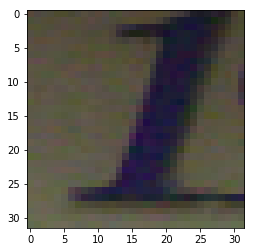

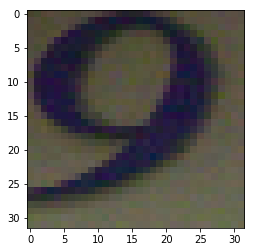

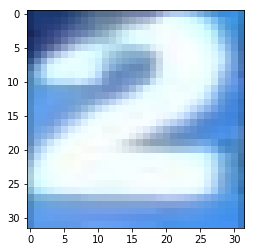

In [18]:
def predict(array_set):
    y_pred      = model.predict(array_set)
    return np.array([np.argmax(pred) * 1.0 for pred in y_pred])

samples = 3
print(predict(resized_images[:samples]))

for i in range(samples):
    display(resized_images, tmp_labels, i)

In [19]:
# TESTING
X  = 'test_digit_features.npy'
y  = 'test_digit_labels.npy'

test_features = np.load(os.path.join(data_dir, X))
test_labels   = np.load(os.path.join(data_dir, y))

print(test_features.shape)
print(test_labels.shape)

(26032,)
(26032,)


In [20]:
tmp_test_features, tmp_test_labels = remove_zero_dims(test_features, test_labels)
#test_cropped = crop(tmp_test_features, 50)
test_resized = resize_32x32(tmp_test_features)

ERROR: float division by zero. DIMS: 662 18 0
ERROR: float division by zero. DIMS: 842 60 0
ERROR: float division by zero. DIMS: 1017 52 0
ERROR: float division by zero. DIMS: 5186 71 0
ERROR: float division by zero. DIMS: 10451 16 0
ERROR: float division by zero. DIMS: 15199 36 0
ERROR: float division by zero. DIMS: 17710 21 0
ERROR: float division by zero. DIMS: 24752 60 0


In [21]:
#test_predictions = predict(test_cropped)
test_predictions = predict(test_resized)

In [22]:
def get_accuracy(pred, test):
    correct = 0
    for i in range(len(pred)):
        if pred[i] == test[i]:
            correct += 1
            
    return (correct*1.0) / len(pred)

accuracy = get_accuracy(test_predictions, tmp_test_labels)
print("Accuracy: {}".format(accuracy*100))

Accuracy: 83.66507838917921
